In [1]:
import math
import numpy as np
from multiprocessing import Process, Manager


class TF_IDF():
    def __init__(self):
        self._doc_all = {}
        self._bow = []
        self._bow_idf = {}
    
    def bag_of_word(self, token_doclist):
        bag_words = list()
        for key in doc_all.keys():
            bag_words += doc_all[key]
        
        bag_words = set(bag_words)
        
        self._bow = bag_words
        return bag_words
    
    def tf(self, term, token_doc):
        tf = token_doc.count(term)/len(token_doc)
        return tf

    # create function to calculate how many doc contain the term 
    def numDocsContaining(self, word, token_doclist):
        doccount = 0
        for doc_token in token_doclist:
            if doc_token.count(word) > 0:
                doccount +=1
        return doccount
    
    # create function to calculate  Inverse Document Frequency in doclist - this list of all documents
    def idf(self, word, token_doclist):
        n = len(token_doclist)
        df = self.numDocsContaining(word, token_doclist)
        return math.log10(n/df)
    
    # calculate idf for every word in bag_words
    def bow_idf(self, token_doclist, multi_processing=None):
        bow = self.bag_of_word(token_doclist)
        
        bag_words_idf = dict()
        
        bag_words_len = len(bow)
        bag_word_10 = round(bag_words_len/10,0)
        print("the number of term in bag_word", bag_words_len)
        print("Start idf processing")
        
        
        ### multi processing ###    
        if multi_processing:
            def compute_idf(i, bag_words_idf, bow, token_doclist):
                for word in bow:
                    bag_words_idf[word] = self.idf(word, token_doclist)
                print('Finish Process', i)
            
            manager = Manager()
            bag_words_idf = manager.dict()
    
            print('Process in mutli-processing mode')
            
            batch_size = round(bag_words_len/multi_processing)
            dataset = []
            start_idx = 0
            end_idx = batch_size
            for i in range(multi_processing):
                if i != multi_processing:
                    dataset.append(list(bow)[start_idx:end_idx])
                    start_idx += batch_size
                    end_idx += batch_size
                else:
                    dataset.append(list(bow)[end_idx:])

            processes = []
            for i in range(multi_processing):
                processes.append(Process(target=compute_idf, args=(i, bag_words_idf, dataset[i], token_doclist)))
                processes[i].start()
                
                print('Start Process', i)

            for i in range(multi_processing):
                processes[i].join()
            
        else:
            i=0
            for word in bow:
                i+=1
                if (i%bag_word_10==0):
                    print("finish %s idf processing" %(str(round(i*10/bag_word_10))+"%"))
                bag_words_idf[word]= self.idf(word, token_doclist)

        
        print("finish idf processing")
        self._bow_idf = bag_words_idf
        return bag_words_idf

    # define a function to do cosine normalization a data dictionary
    def cos_norm(self, dic): # dic is distionary data structure
        dic_norm = {}
        factor = 1.0/np.sqrt(sum([np.square(i) for i in dic.values()]))
        for k in dic:
            dic_norm[k] = dic[k]*factor
        return dic_norm

    # create function to calculate normalize tfidf 
    def compute_tfidf(self, token_doc, bag_words_idf):
        tfidf_doc = {}
        for word in set(token_doc):
            tfidf_doc[word] = self.tf(word,token_doc) * bag_words_idf[word]   
        tfidf_norm = self.cos_norm(tfidf_doc)
        return tfidf_norm
    
    def tfidf(self, token_doclist, bag_words_idf):
        tfidf = {}
        
        for doc in doc_all.keys():
            tfidf[doc]= self.compute_tfidf(doc_all[doc], bag_words_idf)
        
        finish_time = datetime.now(timezone('Asia/Taipei')).strftime("%H:%M:%S")
        
        print("finish tfidf processing at", finish_time)
        return tfidf

    # create normalize term frequency
    def tf_norm(self, token_doc):
        tf_norm={}
        for term in token_doc:
            tf = token_doc.count(term)/len(token_doc)
            tf_norm[term] = tf
        tf_max = max(tf_norm.values())
        for term, value in tf_norm.items():
            tf_norm[term] = 0.5 + 0.5*value/tf_max
        return tf_norm

    def compute_tfidf_query(self, query_token, bag_words_idf):
        tfidf_query = {}
        tf_norm_query = self.tf_norm(query_token)
        for term, value in tf_norm_query.items():
            tfidf_query[term] = value * bag_words_idf[term]
        return tfidf_query

In [2]:
import os
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from datetime import datetime
from pytz import timezone
import pandas as pd
from scipy.spatial.distance import cosine
from wordcloud import WordCloud
import matplotlib.pyplot as plt

now = datetime.now(timezone('Asia/Taipei'))
nltk.download('punkt')


class QueryEngine(TF_IDF):
    def __init__(self):
        super().__init__()
        
        self.stopwords = self._load_stopwords()
        
    def _load_stopwords(self):
        sw = set(stopwords.words('english'))
        my_stopwords = [".", ",", "'ll", "'re", "'s", "!", "'ve", ",', ", "''", "``", "--", "n't", "?"]
        sw = list(sw) + my_stopwords
        return sw
    
    def tokenize(self, doc_list):
        doc_all = dict()
        
        for doc in doc_list:
            title = doc['title']
            tokens = nltk.word_tokenize(doc['description'])
            token_filtered = [w.lower() for w in tokens if w.isalpha()]
            doc_all[title] = token_filtered
            
        self._doc_all = doc_all
        return doc_all
    
    def text_preprocessing(self, doc_all, remove_stopwords=False, selective_POS=[]):
        if remove_stopwords == True:
            for key in doc_all.keys():
                doc_all[key] = [w for w in doc_all[key] if w not in self.stopwords]
                
        if selective_POS != []:
            for key in doc_all.keys():
                pos_tokens_list = nltk.pos_tag(doc_all[key])
                
                selective_pos_tkns = []
                for tkn in pos_tokens_list:
                    if tkn[1] in selective_POS:
                        selective_pos_tkns.append(tkn[0])

                doc_all[key] = selective_pos_tkns
        return doc_all
    
    def tfidf_query(self, doc_all, bow_idf, query, topK=10):
        query_token_raw = nltk.word_tokenize(query)
        query_token = [term for term in query_token_raw if term in self._bow]
        query_result = self.compute_tfidf_query(query_token, bow_idf) # calculate tfidf for query text
        
        # add tfidf of query text to tfidf of all doc and convert to dataframe
        tfidf = self.tfidf(doc_all, bow_idf)
        tfidf["query"] = query_result

        tfidf_df = pd.DataFrame(tfidf).transpose()
        tfidf_df = tfidf_df.fillna(0) # replace all NaN by zero
        
        cosine_sim = {}
        for row in tfidf_df.index:
            if row != "query":
                cosine_sim[row]= 1-cosine(tfidf_df.loc[row], tfidf_df.loc["query"])

        # the top k relevant document
        if topK:
            cosine_sim = dict(sorted(cosine_sim.items(), key=lambda item: item[1], reverse=True)[:topK])
        else:
            cosine_sim = dict(sorted(cosine_sim.items(), key=lambda item: item[1], reverse=True))
        
        return cosine_sim
    
    def show_plot(self, query_result, isSave=False, file_name=''):
        data = query_result
        plt.barh(range(len(data)), list(data.values()), align='center', alpha=0.8)
        plt.yticks(range(len(data)), list(data.keys())) # label for y axis
        plt.xlabel('Smimilarity score')
        plt.ylabel('Course')

        # save graph
        if isSave:
            if not file_name:
                file_name = 'barchart'
            plt.savefig(file_name+".png", bbox_inches='tight', dpi=600)
            
        plt.show()
        
    def show_wordcloud(self, query_result, with_weight=False):
        wc = WordCloud(background_color="white", max_words=1000)
        
        query_bow = set()
        for title in query_result.keys():
            for w in self._doc_all[title]:
                if w in self._bow_idf.keys():
                    query_bow.add(w)
                
        query_bow_idf = {}
        for term in query_bow:
            query_bow_idf[term] = self._bow_idf[term]
        
        if with_weight:
            print(query_bow_idf)
        
        wc.generate_from_frequencies(query_bow_idf)
        plt.imshow(wc)
        plt.axis("off")
        plt.show()

[nltk_data] Downloading package punkt to /Users/jensonsu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from gensim.models import word2vec
import multiprocessing

class RecommendEngine(QueryEngine):
    def __init__(self):
        super().__init__()
        self._corpus_path = 'seg_text.txt'
        self._model = None
        
    def _preprocessing_corpus(self, doc_all):
        with open(self._corpus_path, 'w', encoding='utf8') as output:
            for title in doc_all.keys():
                for word in doc_all[title]:
                    output.write(word + ' ')
                output.write('\n')
        print('finish preprcoessing corpus!')
        

    def train_word2vec_model(self, doc_all, vector_size=50, window=3, min_count=0, sg=0, negative=5):
        self._preprocessing_corpus(doc_all)
        
        sentences = word2vec.LineSentence(self._corpus_path)
        self._model = word2vec.Word2Vec(sentences, size=vector_size, window=window, min_count=min_count,
                          workers=multiprocessing.cpu_count(), sg=sg, negative=negative)
        print('fininsh train word2vec model!')
        
        
    def recommend(self, doc_all, bow_idf, query, topK=10, concept_mode=False, concept_weight=0.5):
        sim = self.tfidf_query(doc_all, bow_idf, query, topK=None)
        
        query_token_raw = nltk.word_tokenize(query)
        query_token = [term for term in query_token_raw if term in self._bow]
        
        # 導入concept機制
        if concept_mode:
            print('Process in concept mode')
            
            if not self._model:
                print('Error: Please train word2vec model then you can use concept mode')
                return
        
        
            print('Successfully load word2vec model')
            threshold = 0.85
            
            for title in doc_all.keys():
                concept_score = 0.0
                count = 0
                for doc_tkn in doc_all[title]:
                    for query_tkn in query_token:
                        res = self._model.wv.similarity(query_tkn, doc_tkn)
                        if res > threshold:
                            concept_score += res * bow_idf[doc_tkn]
                            count += 1
                if count != 0:
                    concept_score = concept_score/count
                    sim[title] = sim[title] + concept_weight*concept_score
                    
        # the top k relevant document
        if topK:
            sim = dict(sorted(sim.items(), key=lambda item: item[1], reverse=True)[:topK])
        else:
            sim = dict(sorted(sim.items(), key=lambda item: item[1], reverse=True))
        
        return sim

# Netflix Dataset

In [4]:
import csv

netflix_data = []
with open('netflix_titles.csv', newline='') as csvfile:
    rows = csv.reader(csvfile)
    
    for row in list(rows)[1:]:
        d = {
            'show_id': row[0],
            'type': row[1],
            'title': row[2],
            'director': row[3],
            'cast': row[4],
            'country': row[5],
            'date_added': row[6],
            'release_year': row[7],
            'rating': row[8],
            'duraiton': row[9],
            'listed_in': row[10],
            'description': row[11]
        }
        netflix_data.append(d)

In [5]:
rec_engine = RecommendEngine()

doc_all = rec_engine.tokenize(netflix_data)

In [6]:
selective_pos = ['NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ']
# selective_pos = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ']

doc_all_feature = rec_engine.text_preprocessing(doc_all, remove_stopwords=True, selective_POS=selective_pos)
bow_idf = rec_engine.bow_idf(doc_all_feature.values(), multi_processing=4)

the number of term in bag_word 14951
Start idf processing
Process in mutli-processing mode
Start Process 0
Start Process 1
Start Process 2
Start Process 3
Finish Process 2
Finish Process 3
Finish Process 1
Finish Process 0
finish idf processing


finish preprcoessing corpus!
fininsh train word2vec model!
finish tfidf processing at 13:55:20
Process in concept mode
Successfully load word2vec model


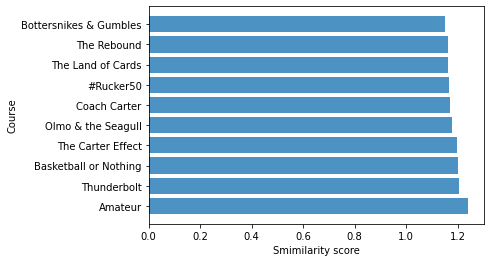

In [7]:
query = "the man play basketball"

rec_engine.train_word2vec_model(doc_all_feature)
query_result = rec_engine.recommend(doc_all_feature, bow_idf, query, concept_mode=True)
rec_engine.show_plot(query_result)

{'team': 1.6412068047357309, 'navajo': 3.7904259173911106, 'recruited': 2.676482565084274, 'scene': 2.711244671343486, 'confrontation': 3.188365926063148, 'prep': 2.9453278773768536, 'bring': 2.118328059455393, 'academic': 3.091455913055092, 'win': 2.0422378903849103, 'women': 1.6970042322288756, 'high': 1.663321119026303, 'nation': 2.559976996012837, 'troops': 3.188365926063148, 'culture': 2.0195739057489663, 'elite': 2.1883659260631485, 'play': 2.2222241933241156, 'phenom': 3.7904259173911106, 'ken': 2.7904259173911106, 'fascist': 3.4893959217271293, 'classic': 2.146973240904923, 'preparation': 3.4893959217271293, 'squadron': 3.4893959217271293, 'puts': 2.5351534122878046, 'nba': 3.3133046626714484, 'shown': 3.4893959217271293, 'royal': 2.428698081373518, 'kids': 1.9643511146902843, 'supply': 3.188365926063148, 'wheelchair': 3.3133046626714484, 'difficult': 2.6442978817128724, 'controversial': 2.392485908719073, 'basketball': 2.836183407951786, 'poor': 2.428698081373518, 'odds': 2.55

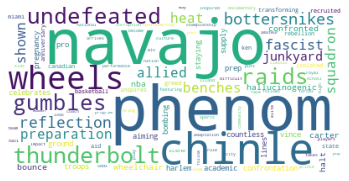

In [8]:
rec_engine.show_wordcloud(query_result, with_weight=True)

# Word2Vec

In [ ]:
# put all sentence together

with open('seg_text.txt', 'w', encoding='utf8') as output:
    for title in doc_all_feature.keys():
        for word in doc_all_feature[title]:
            output.write(word + ' ')
        output.write('\n')

In [ ]:
from gensim.models import word2vec
import multiprocessing

sentences = word2vec.LineSentence("seg_text.txt")
model = word2vec.Word2Vec(sentences, size=250, window=3, min_count=0,
                          workers=multiprocessing.cpu_count(), sg=0, negative=5)

In [ ]:
query_word = 'women'
res = model.wv.most_similar(query_word, topn = 10)
    
for item in res:
    print(item[0]+","+str(item[1]))

In [ ]:
res = model.wv.similarity('woman', 'girl')
print(res)